<h2> <center> Fraud Detection in Financial Transactions </center> </h2>

<br>


Submitted By:-

**Sumeet Ghumare** (**2347057**)


### Import necessary libraries


In [1]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import preprocessing 
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from lightgbm.sklearn import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay


import warnings
warnings.filterwarnings('ignore')

### Load the dataset


In [2]:
def load_dataset(file_path):
    try:
        # Load the dataset
        dataset = pd.read_csv(file_path)
        print("Dataset loaded successfully.")
        return dataset
    except Exception as e:
        print(f"Error loading the dataset: {e}")
        return None

Here, the data was loaded.

In [3]:
file_path = 'financial_transactions_dataset.csv'
df         = load_dataset(file_path)

Dataset loaded successfully.


### Dataset

Display the first few rows of the dataset to get an overview

In [4]:
df.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0


### Rows and Columns

There are **6362620 rows** and **11 columns** present in data set i.e., before cleaning.

In [5]:
df.shape

(6362620, 11)

### Exploring the variables

Exploring the *datatypes* and *number of instances* in the dataset

In [6]:
print(df.type.value_counts())
print('-------------------------------------------------------')
print(df.isFraud.value_counts())
print('-------------------------------------------------------')

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64
-------------------------------------------------------
isFraud
0    6354407
1       8213
Name: count, dtype: int64
-------------------------------------------------------


In [7]:
# Calculate the percentage distribution of transaction_type
transaction_type_percentage = df['type'].value_counts(normalize = True) * 100
transaction_type_percentage

type
CASH_OUT    35.166331
PAYMENT     33.814608
CASH_IN     21.992261
TRANSFER     8.375622
DEBIT        0.651178
Name: proportion, dtype: float64

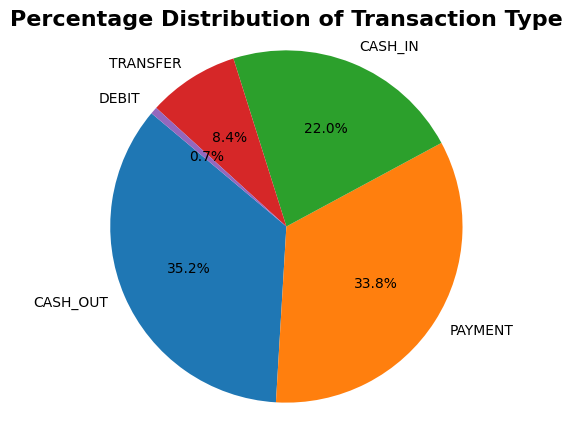

In [8]:
# Ploting the percentage distribution of transaction_type
plt.figure(figsize=(5, 5))
plt.pie(transaction_type_percentage, labels=transaction_type_percentage.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage Distribution of Transaction Type', fontsize=16, fontweight='bold')
plt.axis('equal') 
plt.show()


CASH_OUT and PAYMENT has **higher data points**. 

DEBIT has the **lowest data points**.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Let's break down each column which is provided in the dataset:

**1. step:** It represents a unit of time in the real world, where 1 step is equivalent to 1 hour. It has values like 1, 2, 3, ..., 744 (for a 30-day simulation).

**2. type:** It categorizes the type of transaction. And the type are like PAYMENT, TRANSFER, CASH-IN, CASH-OUT, DEBIT.

**3. amount:** It denotes the amount of the transaction in the local currency. It has values like  9839.64, 1864.28, 181, ...

**4. nameOrig:** It represents the customer who initiated the transaction. It has values like C1231006815, C1666544295, ...

**6. oldbalanceOrg:** It signifies the initial balance of the originator's account before the transaction. It has values like 170136, 21249, 181, ...

**7. newbalanceOrig:** It reflects the new balance of the originator's account after the transaction.It has values like 160296.36, 19384.72, 0, ...

**8. nameDest:** It represents the customer who is the recipient of the transaction. It has values like M1979787155, M2044282225, C553264065, ...

**9. oldbalanceDest:** Indicates the initial balance of the recipient's account before the transaction.
Example: 0, 0, 0, 21182, 0, ...

**10. newbalanceDest:** Denotes the new balance of the recipient's account after the transaction.
Example: 0, 0, 0, 0, 0, ...

**11. isFraud:** It identifies transactions made by fraudulent agents within the simulation. And the values like **0** means *Not fraud*, **1** means *Fraud*.

**12. isFlaggedFraud:** It reflects whether the transaction is flagged as illegal based on the business model. And it has values like **0** (Not flagged as fraud), **1** (Flagged as fraud).


**Note:-** The *memory usage* is  **534.0+ MB**. And *time taken* to load the dataset is ____.

###  Data types in the dataset


In [10]:
# Count of types of data type
df.dtypes.value_counts()

float64    5
int64      3
object     3
Name: count, dtype: int64

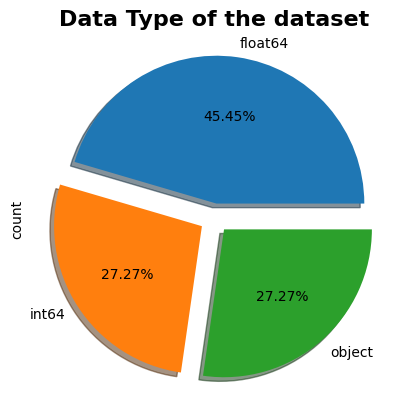

In [11]:
df.dtypes.value_counts().plot.pie(explode = [0.1,0.1,0.1],autopct = '%1.2f%%',shadow = True)
plt.title('Data Type of the dataset', fontweight = 'bold', fontsize = 16);

There is **3 Integer (27.27%)**, **3 Object (27.27%)**, and **5 Float (45.45%)** are present before pre-processing of dataset.

### Check basic statistics of the dataset

Let's have a look to the description of the dataset

In [12]:
df.describe(include='all')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6362620,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
unique,NaN,5,NaN,6353307,NaN,NaN,2722362,NaN,NaN,NaN,NaN
top,NaN,CASH_OUT,NaN,C1902386530,NaN,NaN,C1286084959,NaN,NaN,NaN,NaN
freq,NaN,2237500,NaN,3,NaN,NaN,113,NaN,NaN,NaN,NaN
mean,2.433972e+02,NaN,1.798619e+05,NaN,8.338831e+05,8.551137e+05,NaN,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,NaN,6.038582e+05,NaN,2.888243e+06,2.924049e+06,NaN,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,NaN,1.338957e+04,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,NaN,7.487194e+04,NaN,1.420800e+04,0.000000e+00,NaN,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,NaN,2.087215e+05,NaN,1.073152e+05,1.442584e+05,NaN,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00


## Exploratory Data Analysis

### Na Values


In [13]:
missing_values  = df.isnull().sum()
print("\nThe total NULL values in the dataset are", missing_values.sum())

print("\nThe missing values and the percentage of missing in each columns are given below:-")
# df.isnull().sum()

percent_missing = df.isnull().sum()/df.shape[0]*100

value = {
    'missing_values' : missing_values,
    'percent_missing': percent_missing
}
frame = pd.DataFrame(value)
frame


The total NULL values in the dataset are 0

The missing values and the percentage of missing in each columns are given below:-


,missing_values,percent_missing
step,0,0.0
type,0,0.0
amount,0,0.0
nameOrig,0,0.0
oldbalanceOrg,0,0.0
newbalanceOrig,0,0.0
nameDest,0,0.0
oldbalanceDest,0,0.0
newbalanceDest,0,0.0
isFraud,0,0.0


### Duplicates

Checking the Duplicates in the dataset.

In [14]:
print("\nThe total Duplicates values in the dataset are", df.duplicated().sum()) 


The total Duplicates values in the dataset are 0


### Numerical values:-


In [15]:
numerical_cols = [f for f in df.columns if df.dtypes[f] != 'object']
print("The numirical values in the dataset are given below:- \n",numerical_cols)

The numirical values in the dataset are given below:- 
 ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


### Categorical Values:-


In [16]:
cat_columns = [f for f in df.columns if df.dtypes[f] == 'object']
cat_columns.remove('nameOrig')
cat_columns.remove('nameDest')
print("The Categorical values in the dataset are given below:- \n",cat_columns)

The Categorical values in the dataset are given below:- 
 ['type']


### Checking columns names

In [17]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

### Rename the Columns

Changing the names of the columns for better understanding.

In [18]:
# Define a dictionary with the mapping of old column names to new column names (for better naming convention).
column_mapping = {
    'step'                       : 'step',
    'type'                       : 'transaction_type',
    'amount'                     : 'amount',
    'nameOrig'                   : 'transaction_origin',
    'oldbalanceOrg'              : 'sender_old_balance', 
    'newbalanceOrig'             : 'sender_new_balance', 
    'nameDest'                   : 'transaction_destination', 
    'oldbalanceDest'             : 'receiver_old_balance', 
    'newbalanceDest'             : 'receiver_new_balance', 
    'isFraud'                    : 'is_fraud',
    'isFlaggedFraud'             : 'is_flaggedFraud'
}


# Rename the columns in the DataFrame
df.rename(columns = column_mapping, inplace = True)

# Display the updated DataFrame
df.head(5)


,step,transaction_type,amount,transaction_origin,sender_old_balance,sender_new_balance,transaction_destination,receiver_old_balance,receiver_new_balance,is_fraud,is_flaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Data cleaning

**Removing Non-Essential Columns**

It's advisable to remove non-essential columns from a dataset, and we can achieve this by utilizing the drop function:-

- step, and 

- isFlaggedFraud.

In [19]:
df = df.drop(
    columns = ['step', 'is_flaggedFraud'], 
    axis    = 'columns'
)

**Relocating Target Column**

Now, we are ready to relocate the target column to the preferred position within the dataset.

In [20]:
cols         = df.columns.tolist()
new_position = 3

cols.insert(new_position, cols.pop(cols.index('transaction_destination')))
df           = df[cols]

By employing the head function again, let's confirm the modifications made thus far.

In [21]:
df.head(5)

,transaction_type,amount,transaction_origin,transaction_destination,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,is_fraud
0,PAYMENT,9839.64,C1231006815,M1979787155,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,1864.28,C1666544295,M2044282225,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,181.00,C1305486145,C553264065,181.0,0.00,0.0,0.0,1
3,CASH_OUT,181.00,C840083671,C38997010,181.0,0.00,21182.0,0.0,1
4,PAYMENT,11668.14,C2048537720,M1230701703,41554.0,29885.86,0.0,0.0,0


### Fraudulent vs Legitimate


The result below indicates a significant imbalance in the dataset, with *legitimate transactions* comprising **99.87%** and *fraudulent transactions* only **0.13%**. Hence, we need to use SMOT technique before applying machine learning model.

In [22]:
legit = len(df[df.is_fraud == 0])
fraud = len(df[df.is_fraud == 1])
legit_percent = (legit / (fraud + legit)) * 100
fraud_percent = (fraud / (fraud + legit)) * 100

print("The Number of the Legit Transactions: ", legit)
print("The Number of the Fraud Transactions: ", fraud)
print("\nThe Percentage of the Legit Transactions: {:.4f} %".format(legit_percent))
print("The Percentage of the Fraud Transactions: {:.4f} %".format(fraud_percent))

The Number of the Legit Transactions:  6354407
The Number of the Fraud Transactions:  8213

The Percentage of the Legit Transactions: 99.8709 %
The Percentage of the Fraud Transactions: 0.1291 %


### Correlation heatmap


In [23]:
# Exclude non-numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

# Display correlation matrix
print(correlation_matrix)

                        amount  sender_old_balance  sender_new_balance  \
amount                1.000000           -0.002762           -0.007861   
sender_old_balance   -0.002762            1.000000            0.998803   
sender_new_balance   -0.007861            0.998803            1.000000   
receiver_old_balance  0.294137            0.066243            0.067812   
receiver_new_balance  0.459304            0.042029            0.041837   
is_fraud              0.076688            0.010154           -0.008148   

                      receiver_old_balance  receiver_new_balance  is_fraud  
amount                            0.294137              0.459304  0.076688  
sender_old_balance                0.066243              0.042029  0.010154  
sender_new_balance                0.067812              0.041837 -0.008148  
receiver_old_balance              1.000000              0.976569 -0.005885  
receiver_new_balance              0.976569              1.000000  0.000535  
is_fraud           

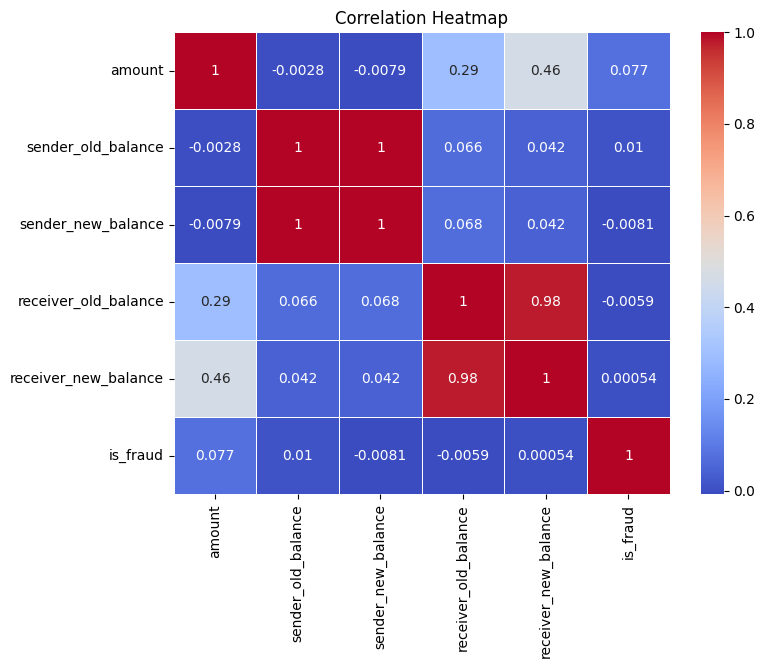

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Based on the correlation matrix:

**1. Transaction Amount:** Transaction amounts have a *positive correlation* with the balances of the receiver. Larger transaction amounts are associated with higher receiver balances.

**2. Balances:** Strong *positive correlation* between the sender's old and new balances (who has started the transaction). Weak positive correlations between sender balances and receiver balances was observed.

**3. Fraud:** *Very weak correlations* between fraud and other columns, with the *highest correlation* being with the transaction amount. The observed correlations are not strong, suggesting that linear relationships are minimal.

Correlation does not imply causation, and further analysis may be required for a comprehensive understanding of relationships in the data.

### Skewness

In [25]:
numeric_df.skew()

amount                  30.993949
sender_old_balance       5.249136
sender_new_balance       5.176884
receiver_old_balance    19.921758
receiver_new_balance    19.352302
is_fraud                27.779538
dtype: float64

#### Insights

- The *amount* is **Highly right-skewed (positively skewed)**. Also, *receiver_old_balance*, *receiver_new_balance* and *isfraud* are **Highly right-skewed**.

- *sender_old_balance* and *sender_new_balance* are **moderately right-skewed**.


Hence, the financial transaction data exhibits **right-skewness**, indicating a concentration of lower values in the balances and amounts, with a few higher values or fraudulent cases having a substantial impact on the overall distribution.

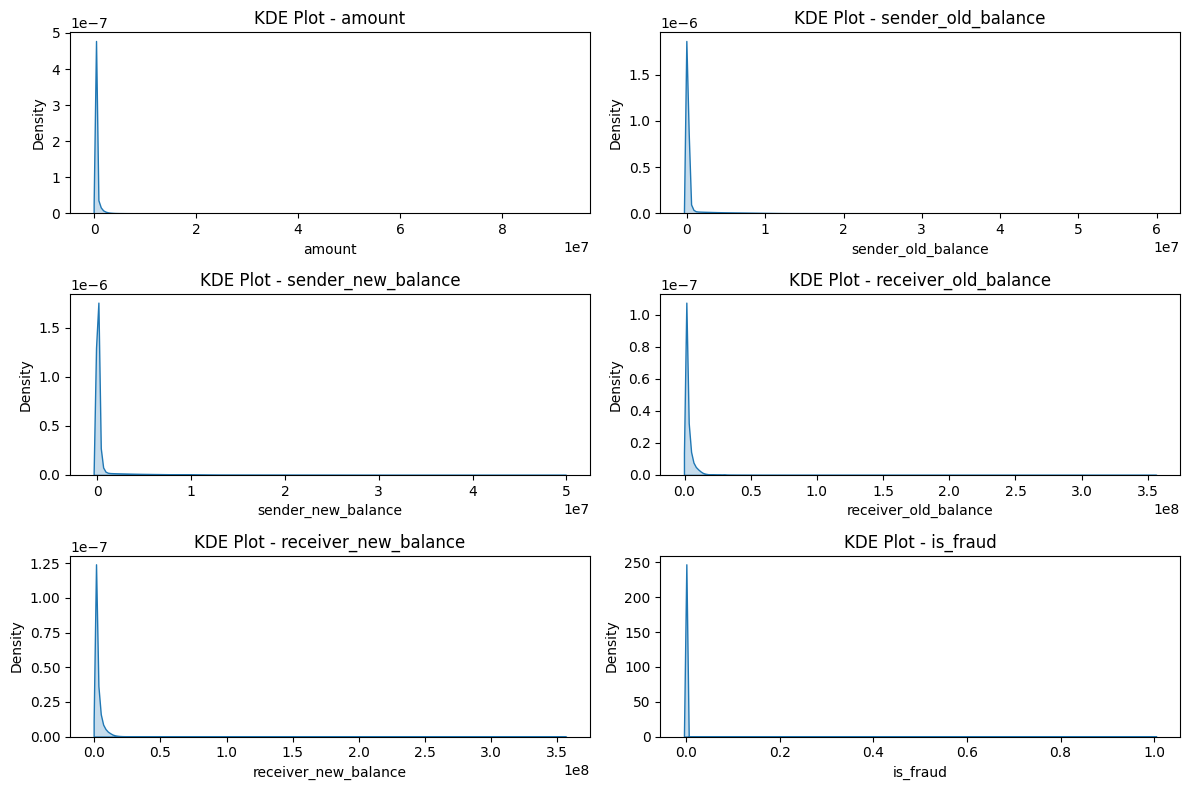

In [26]:
# Assuming df is your DataFrame with the specified columns and data
numeric_columns = ['amount', 'sender_old_balance', 'sender_new_balance', 'receiver_old_balance', 'receiver_new_balance', 'is_fraud']
numeric_df = df[numeric_columns]

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Loop through each numeric column and create a KDE plot
for i, column in enumerate(numeric_df.columns):
    plt.subplot(3, 2, i+1)
    sns.kdeplot(data=numeric_df, x=column, fill=True, common_norm=False, palette='darkblue')
    plt.title(f'KDE Plot - {column}')

plt.tight_layout()
plt.show()


### Fraud and Non Fraud Transactions

Now, we will create a **cluster bar plot** to visualize the distribution of fraud and non-fraud transactions across different transaction types.

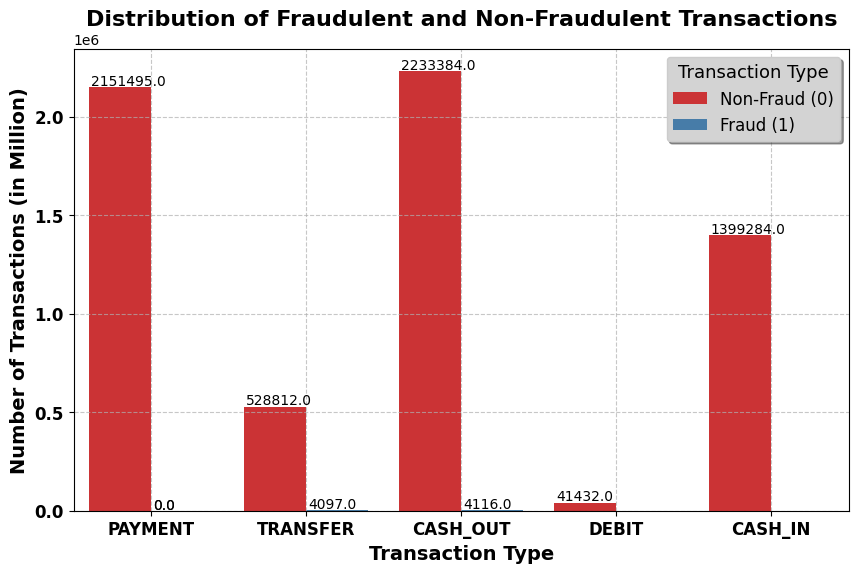

In [27]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x="transaction_type", hue="is_fraud", palette='Set1')
plt.title('Distribution of Fraudulent and Non-Fraudulent Transactions', fontsize=16, fontweight='bold')

# Adding annotations to each bar
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x() + 0.01, p.get_height() + 10000))

# Making x and y-axis labels bold
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

for label in ax.get_xticklabels():
    label.set_fontweight('bold')
for label in ax.get_yticklabels():
    label.set_fontweight('bold')

# Bold x and y-axis labels
ax.set_xlabel('Transaction Type', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Transactions (in Million)', fontsize=14, fontweight='bold')

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Beautify the legend
plt.legend(['Non-Fraud (0)', 'Fraud (1)'], title='Transaction Type', title_fontsize=13, fontsize=12, facecolor='lightgrey', shadow=True, fancybox=True)

plt.show()


#### Insights

- Clustered chart reveals that **fraudulent transactions** predominantly occur within the 'TRANSFER' and 'CASH_OUT' transaction types. 

- The maximun legitimate transaction is done in 'CASH_OUT' and 'PAYMENT' , that is, **2233384** and **2151495**. And it is intresting to know that 'CASH_OUT' have has the maximun fraudulent transactions of **4116**. But 'PAYMENT' does not have any fraudulent transactions.

- The minmum transaction is done in 'DEBIT', that is, **41432**. Also, 'DEBIT' has no fraudulent transactions.

- While the moderate transaction is done in 'CASH_IN' and 'TRANSFER', that is, **1399284** and **528812**. However 'TRANSFER' has **4097** fraudulent transactions and 'CASH_IN' has no fraudulent transactions.

## Origin and Destination of Transactions


### Origin Source

Now, we check the origin source from where the transactions were made in 'TRANSFER'.

In [28]:
transfer_fraud = df[((df['transaction_type'] == 'TRANSFER') & df['is_fraud'] == 1)]
transfer_fraud['transaction_origin'].value_counts()

transaction_origin
C1305486145    1
C202278158     1
C12585107      1
C946427395     1
C1069177491    1
              ..
C2090764492    1
C1794935564    1
C318078280     1
C939293281     1
C1685995037    1
Name: count, Length: 4097, dtype: int64

### Destination Source

and now we will check the destination from where the transactions were cashed out, that is, 'CASH_OUT'.

In [29]:
cash_out_fraud = df[(df['transaction_type'] == 'CASH_OUT') & (df['is_fraud'] == 1)]
cash_out_fraud['transaction_destination'].value_counts()

transaction_destination
C200064275     2
C1399829166    2
C1650668671    2
C2129197098    2
C1013511446    2
              ..
C1566713324    1
C1955464150    1
C1104137869    1
C377165949     1
C873221189     1
Name: count, Length: 4091, dtype: int64

We will aslo check that if the transfer, that is, 'TRANSFER' and receiving account, that is, 'CASH_OUT' was same or not.

In [30]:
transactions_transfer = df[df['transaction_type'] == 'TRANSER']
transactions_cashout  = df[df['transaction_type'] == 'CASH_OUT']

print('Is the receiving account utilized for cashing out ?')
transactions_transfer.transaction_destination.isin(transactions_cashout.transaction_origin).any()

Is the receiving account utilized for cashing out ?


False

#### Insights

- Finally, Fraudulent activities primarily occur in TRANSFER and CASH_OUT transaction types.

- Specifically, there were **4097** fraud transactions in TRANSFER and **4116** in CASH_OUT.

- **Fraudulent transactions** mostly involve transfers from one *customer* to *another customer* , that is, **C** to **C**.

- Notably, the *sender* and *receiver* accounts differ in fraudulent transactions.

## Feature Engineering

Now, we can engage in feature engineering to create *additional columns* that may prove beneficial for subsequent machine learning tasks.

In [31]:
financial_data                         = df.copy()
financial_data['transaction_category'] = np.nan

financial_data.loc[df.transaction_origin.str.contains('C') & df.transaction_destination.str.contains('C'), 'transaction_category'] = 'CC'
financial_data.loc[df.transaction_origin.str.contains('C') & df.transaction_destination.str.contains('M'), 'transaction_category'] = 'CM'
financial_data.loc[df.transaction_origin.str.contains('M') & df.transaction_destination.str.contains('C'), 'transaction_category'] = 'MC'
financial_data.loc[df.transaction_origin.str.contains('M') & df.transaction_destination.str.contains('C'), 'transaction_category'] = 'MM'

This categorization seems to be based on whether the transactions involve **customers** ('C') or **merchants** ('M') at the *origin* and *destination*.

Moreover, '*transaction_category*' reflects the column that categorizes transactions based on the type of entities involved in the transaction, such as:-

- 'CC' for customer-to-customer, 

- 'CM' for customer-to-merchant, 

- 'MC' for merchant-to-customer, and 

- 'MM' for merchant-to-merchant transactions.

Now let's change the coloumn position.

In [32]:
cols           = financial_data.columns.tolist()
new_position   = 1

cols.insert(new_position, cols.pop(cols.index('transaction_category')))
financial_data = financial_data[cols]

Now, we have created a new coloumn which is *categorial*.

Also, we can drop the irrelevant columns such as '*origin*', and '*destination*'.

In [33]:
financial_data.drop(columns = ['transaction_origin','transaction_destination'], axis = 'columns', inplace = True)

In [34]:
financial_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 8 columns):
 #   Column                Dtype  
---  ------                -----  
 0   transaction_type      object 
 1   transaction_category  object 
 2   amount                float64
 3   sender_old_balance    float64
 4   sender_new_balance    float64
 5   receiver_old_balance  float64
 6   receiver_new_balance  float64
 7   is_fraud              int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 388.3+ MB


#### Note:- 

*Memory usage* after Data Featuring is **388.3 MB**. That means, we have also **optimize our dataset** for better *model trainning*, *prediction* and *result*.

In [35]:
financial_data.head(5)

,transaction_type,transaction_category,amount,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,is_fraud
0,PAYMENT,CM,9839.64,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,CM,1864.28,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,CC,181.00,181.0,0.00,0.0,0.0,1
3,CASH_OUT,CC,181.00,181.0,0.00,21182.0,0.0,1
4,PAYMENT,CM,11668.14,41554.0,29885.86,0.0,0.0,0


#### Fraudulent vs Legitimate Transactions

Now, let's see how many **Valid Transactions** made from Customer to Customer (CC) and Customer to Merchant (CM). 

In [36]:
fraud_transactions = financial_data[financial_data['is_fraud'] == 1]

print('The number of Fraud Transactions categorized by Transactions type is as follows:-\n', fraud_transactions.transaction_category.value_counts())

The number of Fraud Transactions categorized by Transactions type is as follows:-
 transaction_category
CC    8213
Name: count, dtype: int64


In [37]:
valid_transactions = financial_data[financial_data['is_fraud'] == 0]

print('The number of Valid Transactions categorized by Transactions type is as follows:-\n', valid_transactions.transaction_category.value_counts())

The number of Valid Transactions categorized by Transactions type is as follows:-
 transaction_category
CC    4202912
CM    2151495
Name: count, dtype: int64


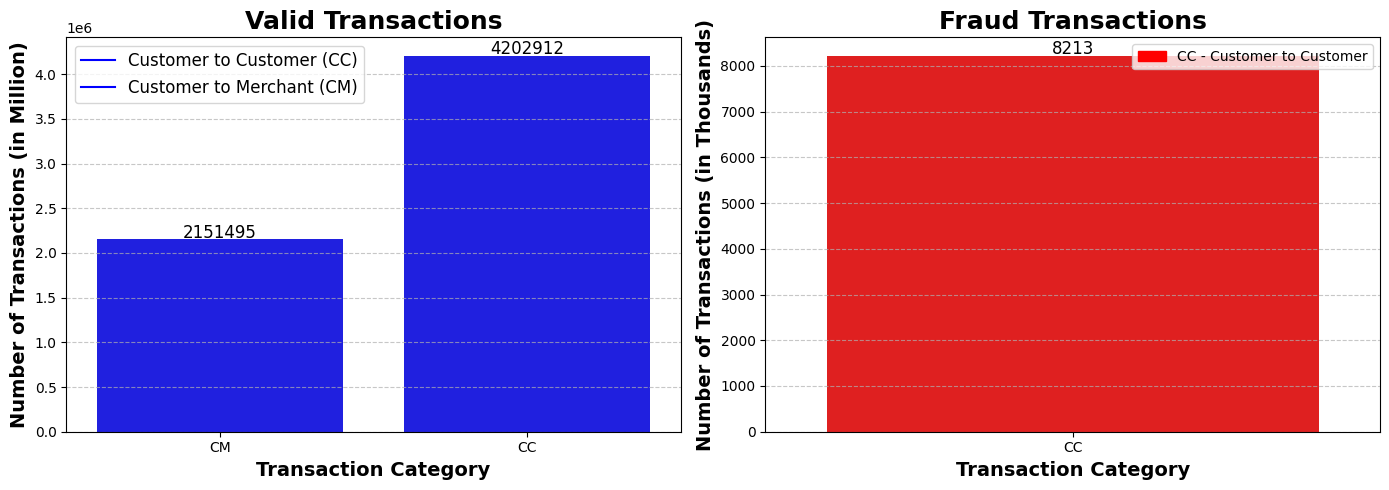

In [38]:
# Set the figure size
plt.figure(figsize=(14, 5))

# Valid Transactions Plot
plt.subplot(1, 2, 1)
ax_valid = sns.countplot(data=valid_transactions, x="transaction_category", color='blue')
plt.title('Valid Transactions', fontsize=18, fontweight='bold')
plt.xlabel('Transaction Category', fontsize=14, fontweight='bold')
plt.ylabel('Number of Transactions (in Million)', fontsize=14, fontweight='bold')
for p in ax_valid.patches:
    ax_valid.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                      textcoords='offset points')
legend_elements_valid = [plt.Line2D([0], [0], color='blue', label='Customer to Customer (CC)'),
                         plt.Line2D([0], [0], color='blue', label='Customer to Merchant (CM)')]
plt.legend(handles=legend_elements_valid, fontsize=12)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Fraud Transactions Plot
plt.subplot(1, 2, 2)
ax_fraud = sns.countplot(data=fraud_transactions, x="transaction_category", color='red')
plt.title('Fraud Transactions', fontsize=18, fontweight='bold')
plt.xlabel('Transaction Category', fontsize=14, fontweight='bold')
plt.ylabel('Number of Transactions (in Thousands)', fontsize=14, fontweight='bold')
for p in ax_fraud.patches:
    ax_fraud.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                      textcoords='offset points')
legend_labels_fraud = {'CC': 'CC - Customer to Customer'}
plt.legend(handles=[plt.Rectangle((0, 0), 1, 1, color='red')],
           labels=[legend_labels_fraud.get("CC")], loc='upper right', fontsize=10)

# Adjust layout
plt.tight_layout()

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


#### Insights 

- The total number of *fraud transactions* amounted to **8213**, all of which were initiated from customer to customer transactions (CC). 

- There were **4,202,912** *valid transactions* from customer to customer (CC) and **2,151,495** *valid transactions* from customer to merchant (CM).

### Transaction Amount Distribution: Fraudulent Transactions

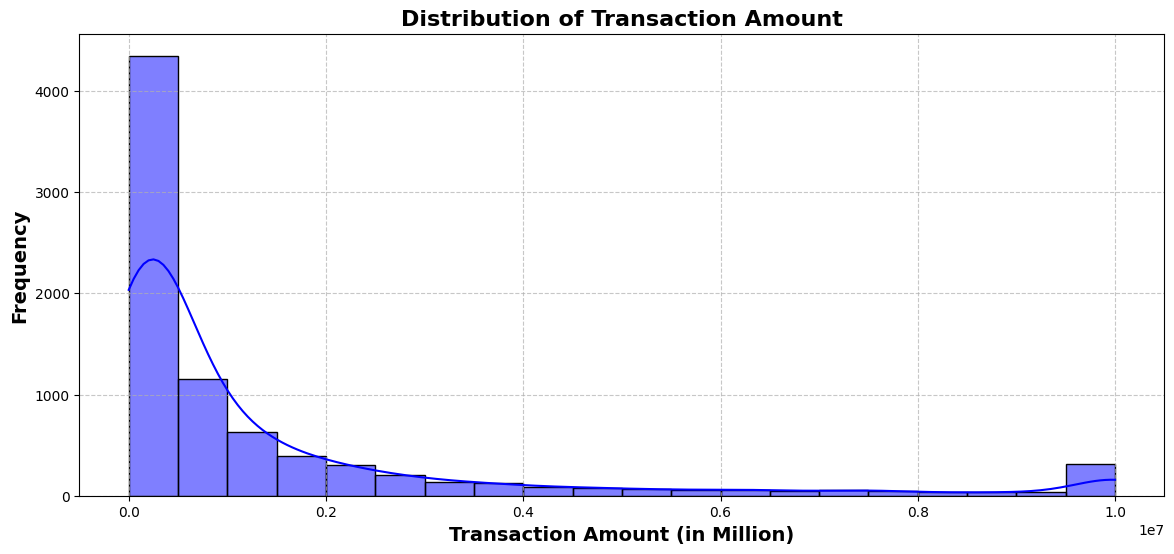

In [39]:
# Set the figure size
plt.figure(figsize=(14, 6))

# Create a histogram of the 'amount' column
sns.histplot(fraud_transactions['amount'], bins=20, color='blue', edgecolor='black', kde=True, linewidth=1)

# Add labels and title
plt.xlabel('Transaction Amount (in Million)', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Transaction Amount', fontsize=16, fontweight='bold')

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

## Model Training

In [40]:
financial_data.head(5)

,transaction_type,transaction_category,amount,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,is_fraud
0,PAYMENT,CM,9839.64,170136.0,160296.36,0.0,0.0,0
1,PAYMENT,CM,1864.28,21249.0,19384.72,0.0,0.0,0
2,TRANSFER,CC,181.00,181.0,0.00,0.0,0.0,1
3,CASH_OUT,CC,181.00,181.0,0.00,21182.0,0.0,1
4,PAYMENT,CM,11668.14,41554.0,29885.86,0.0,0.0,0


#### Model Pre-Processing

**Onehot encoding** is applied to ‘transaction_category’ which contains ‘C’ and ‘M’ values. ‘transaction_type’ is also encoded.

In [41]:
ohe             = preprocessing.OneHotEncoder()                                       
financial_data  = pd.get_dummies(financial_data, columns = ['transaction_type','transaction_category'])
financial_data.head(3)

,amount,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,is_fraud,transaction_type_CASH_IN,transaction_type_CASH_OUT,transaction_type_DEBIT,transaction_type_PAYMENT,transaction_type_TRANSFER,transaction_category_CC,transaction_category_CM
0,9839.64,170136.0,160296.36,0.0,0.0,0,False,False,False,True,False,False,True
1,1864.28,21249.0,19384.72,0.0,0.0,0,False,False,False,True,False,False,True
2,181.00,181.0,0.00,0.0,0.0,1,False,False,False,False,True,True,False


In [42]:
# To save pre-processed dataset
# financial_data.to_csv(folder_path+ 'preprocessed_dataset.csv')

In [43]:
print(len(financial_data.columns))
financial_data.columns

13


Index(['amount', 'sender_old_balance', 'sender_new_balance',
       'receiver_old_balance', 'receiver_new_balance', 'is_fraud',
       'transaction_type_CASH_IN', 'transaction_type_CASH_OUT',
       'transaction_type_DEBIT', 'transaction_type_PAYMENT',
       'transaction_type_TRANSFER', 'transaction_category_CC',
       'transaction_category_CM'],
      dtype='object')

####  Target and Feature Variables:-


In [44]:
# Except 'is_fraud', all the variable are target variable
features = ['amount', 'sender_old_balance', 'sender_new_balance', 'receiver_old_balance', 'receiver_new_balance', 
            'transaction_type_CASH_IN', 'transaction_type_CASH_OUT', 'transaction_type_DEBIT', 'transaction_type_PAYMENT',
            'transaction_type_TRANSFER', 'transaction_category_CC', 'transaction_category_CM']  

# 'is_fraud' is the target variable
target   = ['is_fraud'] 

#### Train and Test Model

Train, test and then split (specifies that **20%** of the data will be used for testing, while **80%** will be used for training). Finally, we will explore the division.

In [45]:
x_train, x_test, y_train, y_test = train_test_split( financial_data[features], financial_data['is_fraud'], test_size = 0.2, random_state = 42)

In [46]:
# Get the length of xtrain.

len(x_train), len(x_test)

(5090096, 1272524)

In [47]:
# Get the length of ytrain.
y_test.value_counts() 

is_fraud
0    1270904
1       1620
Name: count, dtype: int64

We notice an **imbalance in the class** distribution between y_train and y_test, indicating that the training and test sets have imbalanced classes. 

This disparity can lead to suboptimal model performance. Therefore, to address this issue, we employ **sampling techniques** on the *training set* to mitigate the imbalance and improve the model's effectiveness.

#### Synthetic Minority Over-sampling Technique

- To address the class imbalance issue, we utilize **SMOTE** (Synthetic Minority Over-sampling Technique) to oversample the minority class, which in this case is the 'Fraud' (1) class. 

- The minority class is sampled at a ratio of **0.025** times the majority class, ensuring an adequate representation of the minority class in the dataset. Additionally, to further balance the dataset, the 'Not-Fraud' class (0) is undersampled to double the number of instances in the 'Fraud' class. 

- This sampling strategy aims to improve the model's ability to accurately predict instances of fraud while maintaining a balanced representation of both classes.

In [48]:
over         = SMOTE(sampling_strategy=0.025) 

under        = RandomUnderSampler(random_state = 42, sampling_strategy = 0.5)

steps        = [('o', over),('u', under)] 

pipeline     = Pipeline(steps = steps) 

x_res, y_res = pipeline.fit_resample(x_train[features], y_train) 

print(Counter(y_res))

Counter({0: 254174, 1: 127087})


The result suggests that the dataset has been balanced using SMOTE oversampling and Random Under-Sampling, resulting in **254174 instances** of the majority class (Not-Fraud) and **127,087 instances** of the minority class (Fraud).

### Modeling

**Random Forest Classifier**

- We have selected the RandomForestClassifier and Logistic Regression models for our modeling task. 

- The hyperparameters for each model were chosen based on experimentation and prior knowledge. 

- If needed, you can explore more efficient hyperparameters using techniques like RandomizedSearchCV and refer to the documentation for guidance.
Once trained, the model will be saved for future use.

In [49]:
random_forest_classifier = RandomForestClassifier(criterion = 'gini', max_depth = 48, max_features = 'sqrt', n_estimators = 300)
                             
random_forest_classifier.fit(x_res, y_res)

RandomForestClassifier(max_depth=48, n_estimators=300)

In [50]:
# To saving the model
# import joblib
# f_name = folder_path + 'rf_model.sav'
# joblib.dump(clf, f_name)

 Let’s get the **accuracy score** of the model

In [51]:
score          = random_forest_classifier.score(x_test,y_test)
y_preds        = random_forest_classifier.predict(x_test)
rfc_pred_proba = random_forest_classifier.predict_proba(x_test)[:,1]
score, y_preds

(0.9975033869695189, array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

**99.6%** *accuracy* is obtained on test data.

#### Classification Report

In [52]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test, y_preds, digits = 4, target_names = ['Not Fraud','Fraud'])

# Print the classification report
print("Classification Report for Random Forest Classifier:")
print(report)

Classification Report for Random Forest Classifier:
              precision    recall  f1-score   support

   Not Fraud     1.0000    0.9975    0.9987   1270904
       Fraud     0.3361    0.9858    0.5013      1620

    accuracy                         0.9975   1272524
   macro avg     0.6681    0.9917    0.7500   1272524
weighted avg     0.9991    0.9975    0.9981   1272524



### Visualizing Results 

**Confusion Matrix**:- 

We have observed that **22** instances of the 'Fraud' class have been incorrectly predicted as non-fraudulent transactions.

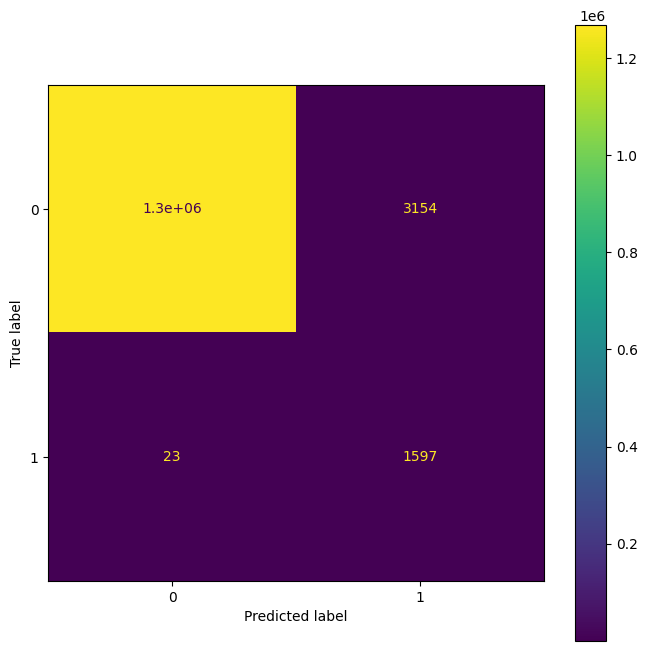

In [53]:
fig, ax = plt.subplots(figsize = (8,8))

ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_preds, ax = ax);

In [54]:
# Random Forest Classifier - Key Terms of Confusion Matrix 

print("TP,FP,TN,FN - Random Forest Classifier")
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
print(f'True Positives (TP): {tp}')
print(f'False Positives (FP): {fp}')
print(f'True Negatives (TN): {tn}')
print(f'False Negatives (FN): {fn}')

TP,FP,TN,FN - Random Forest Classifier
True Positives (TP): 1597
False Positives (FP): 3154
True Negatives (TN): 1267750
False Negatives (FN): 23


### Logistic Regression

In [55]:
logistic_regression_classifier  = LogisticRegression(C = 0.20433597178569418, solver = "liblinear")

logistic_regression_classifier.fit(x_train, y_train); 

Let’s get the accuracy score of the logistics regression classifier model.

In [56]:
score_logistic_regression_classifier   = logistic_regression_classifier.score(x_test, y_test)
y_preds_logistic_regression_classifier = logistic_regression_classifier.predict(x_test)
lrc_pred_proba                         = logistic_regression_classifier.predict_proba(x_test)[:,1]

score_logistic_regression_classifier, y_preds_logistic_regression_classifier 

(0.9992306628401507, array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

#### Classification Report

In [57]:
lr_classification_report = (classification_report(y_test, y_preds_logistic_regression_classifier, digits = 4, target_names = ['Not Fraud','Fraud']))
print("Logistic Regression Classifier:")
print(lr_classification_report)

Logistic Regression Classifier:
              precision    recall  f1-score   support

   Not Fraud     0.9997    0.9996    0.9996   1270904
       Fraud     0.6798    0.7481    0.7123      1620

    accuracy                         0.9992   1272524
   macro avg     0.8397    0.8738    0.8560   1272524
weighted avg     0.9993    0.9992    0.9992   1272524



### Visualizing Results 

**Confusion Matrix**:- 

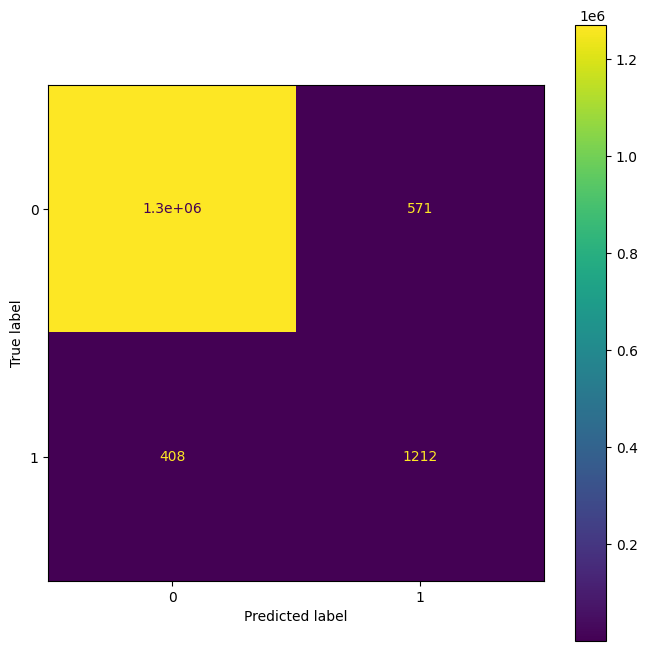

In [58]:
fig, ax = plt.subplots(figsize = (8,8))

ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_preds_logistic_regression_classifier, ax = ax);

In [59]:
# Logistic Regression Classifier - Key Terms of Confusion Matrix 

print("TP,FP,TN,FN - Logistic Regression Classifier")
tn, fp, fn, tp = confusion_matrix(y_test, y_preds_logistic_regression_classifier).ravel()
print(f'True Positives (TP): {tp}')
print(f'False Positives (FP): {fp}')
print(f'True Negatives (TN): {tn}')
print(f'False Negatives (FN): {fn}')

TP,FP,TN,FN - Logistic Regression Classifier
True Positives (TP): 1212
False Positives (FP): 571
True Negatives (TN): 1270333
False Negatives (FN): 408


**Insights:**

Despite logistic regression yielding a higher accuracy rate, the RandomForestClassifier is deemed more dependable. This is because the RandomForestClassifier exhibits a lower rate of false negatives, indicating that instances where 'Fraud' is incorrectly classified as 'non-Fraud' occur less frequently.

# Random Forest Classifier

In [60]:
rfc = RandomForestClassifier(n_estimators = 15, n_jobs = -1, random_state = 42)
rfc.fit(x_train, y_train)

classifiers = []
classifiers.append(rfc)

#### Model evalution

Model evalution of random forest classifier:-

In [61]:
score          = rfc.score(x_test,y_test)
y_preds        = rfc.predict(x_test)
rfc_pred_proba = rfc.predict_proba(x_test)[:,1]
score, y_preds

(0.999684878241982, array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

In [62]:
rfc = (classification_report(y_test, y_preds, digits=4, target_names = ['Not Fraud','Fraud']))
print("Random Forest Classifier:")
print(rfc)

Random Forest Classifier:
              precision    recall  f1-score   support

   Not Fraud     0.9997    1.0000    0.9998   1270904
       Fraud     0.9593    0.7858    0.8639      1620

    accuracy                         0.9997   1272524
   macro avg     0.9795    0.8929    0.9319   1272524
weighted avg     0.9997    0.9997    0.9997   1272524



## LGBM Classifier

In [63]:
lgbm = LGBMClassifier(boosting_type = 'gbdt',objective = 'binary', random_state = 8888)

lgbm.fit(x_train, y_train)

classifiers = []
classifiers.append(lgbm)

[LightGBM] [Info] Number of positive: 6593, number of negative: 5083503
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1289
[LightGBM] [Info] Number of data points in the train set: 5090096, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001295 -> initscore=-6.647747
[LightGBM] [Info] Start training from score -6.647747


#### Model evalution

Model evalution of LGBM Classifier:-

In [64]:
score_lgbm      = lgbm.score(x_test,y_test)
y_preds_lgbm    = lgbm.predict(x_test)
lgbm_pred_proba = lgbm.predict_proba(x_test)[:,1]

score_lgbm, y_preds_lgbm

(0.9983112302793503, array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

#### Classification Report

In [65]:
lgbm = (classification_report(y_test, y_preds_lgbm, digits = 4, target_names = ['Not Fraud','Fraud']))
print("LGBM Classifier:")
print(lgbm)

LGBM Classifier:
              precision    recall  f1-score   support

   Not Fraud     0.9989    0.9994    0.9992   1270904
       Fraud     0.2207    0.1290    0.1628      1620

    accuracy                         0.9983   1272524
   macro avg     0.6098    0.5642    0.5810   1272524
weighted avg     0.9979    0.9983    0.9981   1272524



### Visualizing Results 

**Confusion Matrix**:- 

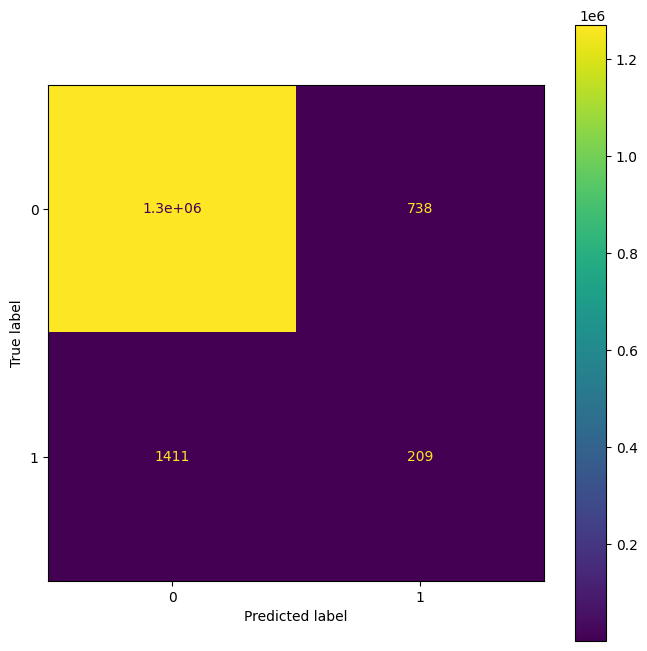

In [66]:
fig, ax = plt.subplots(figsize = (8,8))

ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_preds_lgbm, ax = ax);

In [67]:
# LGBM Classifier - Key Terms of Confusion Matrix 

print("TP,FP,TN,FN - LGBM Classifier")
tn, fp, fn, tp = confusion_matrix(y_test, y_preds_lgbm).ravel()
print(f'True Positives (TP): {tp}')
print(f'False Positives (FP): {fp}')
print(f'True Negatives (TN): {tn}')
print(f'False Negatives (FN): {fn}')

TP,FP,TN,FN - LGBM Classifier
True Positives (TP): 209
False Positives (FP): 738
True Negatives (TN): 1270166
False Negatives (FN): 1411


## Extreme Gradient Boosting

In [68]:
xgbr = xgb.XGBClassifier(max_depth = 5, n_jobs = -1, random_state = 45, learning_rate = 0.2)

xgbr.fit(x_train, y_train)

classifiers.append(xgbr)

#### Model evalution

Model evalution of XGB Classifier:-

In [69]:
score_xgbr      = xgbr.score(x_test,y_test)
y_preds_xgbr    = xgbr.predict(x_test)
xgbr_pred_proba = xgbr.predict_proba(x_test)[:,1]

score_xgbr, y_preds_xgbr

(0.9996605172083198, array([0, 0, 0, ..., 0, 0, 0]))

#### Classification Report

In [70]:
xgbr = (classification_report(y_test, y_preds_xgbr, digits = 4, target_names = ['Not Fraud','Fraud']))
print("XGBoost:")
print(xgbr)

XGBoost:
              precision    recall  f1-score   support

   Not Fraud     0.9997    1.0000    0.9998   1270904
       Fraud     0.9685    0.7580    0.8504      1620

    accuracy                         0.9997   1272524
   macro avg     0.9841    0.8790    0.9251   1272524
weighted avg     0.9997    0.9997    0.9996   1272524



### Visualizing Results 

**Confusion Matrix**:- 

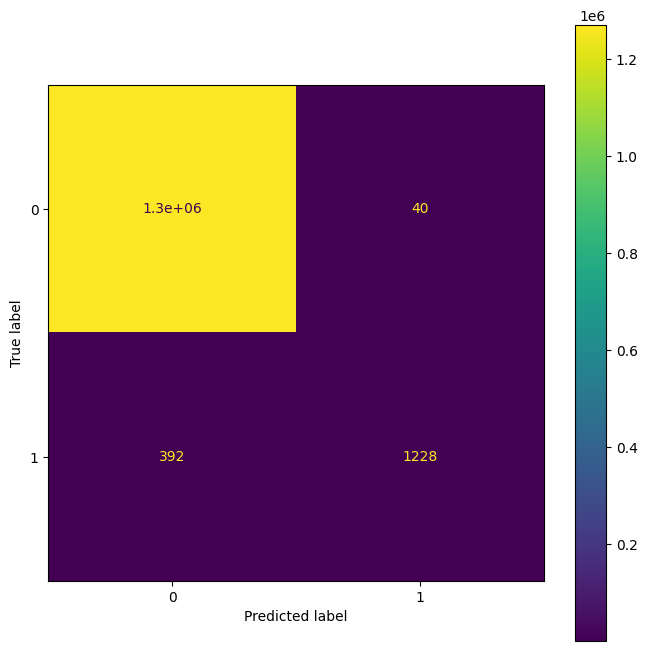

In [71]:
fig, ax = plt.subplots(figsize = (8,8))

ConfusionMatrixDisplay.from_predictions(y_true = y_test, y_pred = y_preds_xgbr, ax = ax);

In [72]:
# XGBoost Classifier - Key Terms of Confusion Matrix 

print("TP,FP,TN,FN - XGBoost Classifier")
tn, fp, fn, tp = confusion_matrix(y_test, y_preds_xgbr).ravel()
print(f'True Positives (TP): {tp}')
print(f'False Positives (FP): {fp}')
print(f'True Negatives (TN): {tn}')
print(f'False Negatives (FN): {fn}')

TP,FP,TN,FN - XGBoost Classifier
True Positives (TP): 1228
False Positives (FP): 40
True Negatives (TN): 1270864
False Negatives (FN): 392


## Logistic Regression

In [73]:
logreg = LogisticRegression(solver = 'liblinear', random_state = 42)

logreg.fit(x_train, y_train)

classifiers.append(logreg)

#### Model evalution

Model evalution of Logistic Regression Classifier:-

In [74]:
score_logreg   = logreg.score(x_test,y_test)
y_preds_logreg = logreg.predict(x_test)
score_logreg, y_preds_logreg

(0.9991332187055019, array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

In [75]:
logreg = (classification_report(y_test, y_preds_logreg, digits = 4, target_names = ['Not Fraud','Fraud']))
print("Logistic Regression:")
print(logreg)

Logistic Regression:
              precision    recall  f1-score   support

   Not Fraud     0.9997    0.9995    0.9996   1270904
       Fraud     0.6383    0.7364    0.6839      1620

    accuracy                         0.9991   1272524
   macro avg     0.8190    0.8679    0.8417   1272524
weighted avg     0.9992    0.9991    0.9992   1272524



# Model Evaluation


#### Random Forest Classifier 

Model evalution Based on **ROC Curve**.

In [76]:
fpr, tpr, temp = roc_curve(y_test, rfc_pred_proba)
auc = round(roc_auc_score(y_test, rfc_pred_proba),3)
auc

0.98

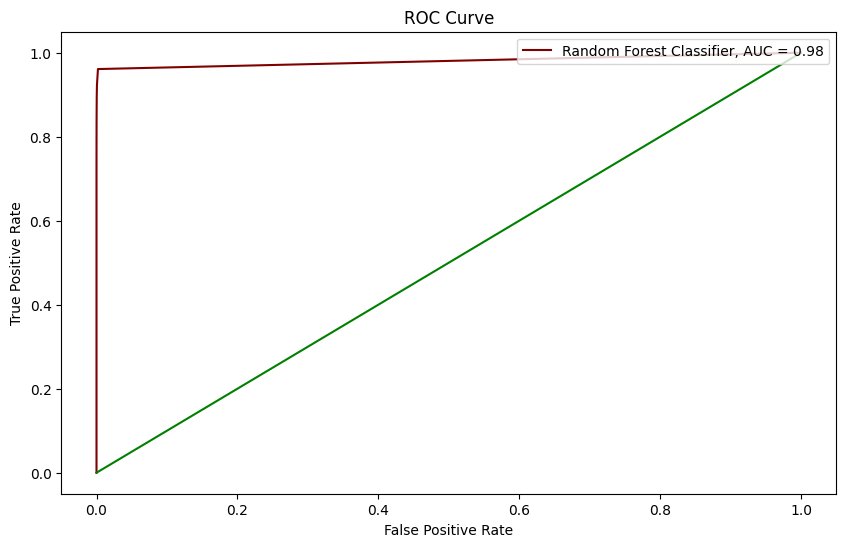

In [77]:
# Making it beautiful
plt.figure(figsize=(10, 6))

plt.plot(fpr, tpr, label = 'Random Forest Classifier, AUC = ' + str(auc), linestyle = 'solid', color = '#800000')
plt.plot([0, 1], [0, 1], color = 'g')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'upper right')

#### Logistic Regression Classifier 

Model evalution Based on **ROC Curve**.

In [78]:
fpr, tpr, temp = roc_curve(y_test, lrc_pred_proba)
auc = round(roc_auc_score(y_test, lrc_pred_proba),3)
auc

0.948

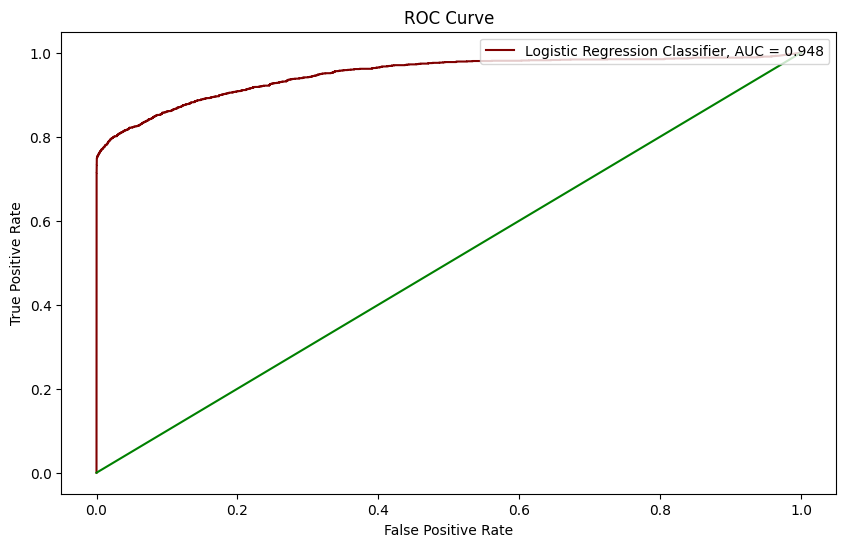

In [79]:
plt.figure(figsize=(10, 6))

plt.plot(fpr, tpr, label = 'Logistic Regression Classifier, AUC = ' + str(auc), linestyle = 'solid', color = '#800000')
plt.plot([0, 1], [0, 1], color = 'g')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'upper right')

#### LGBM Classifier 

Model evalution Based on **ROC Curve**.

In [80]:
fpr, tpr, temp = roc_curve(y_test, lgbm_pred_proba)
auc = round(roc_auc_score(y_test, lgbm_pred_proba),3)
auc

0.437

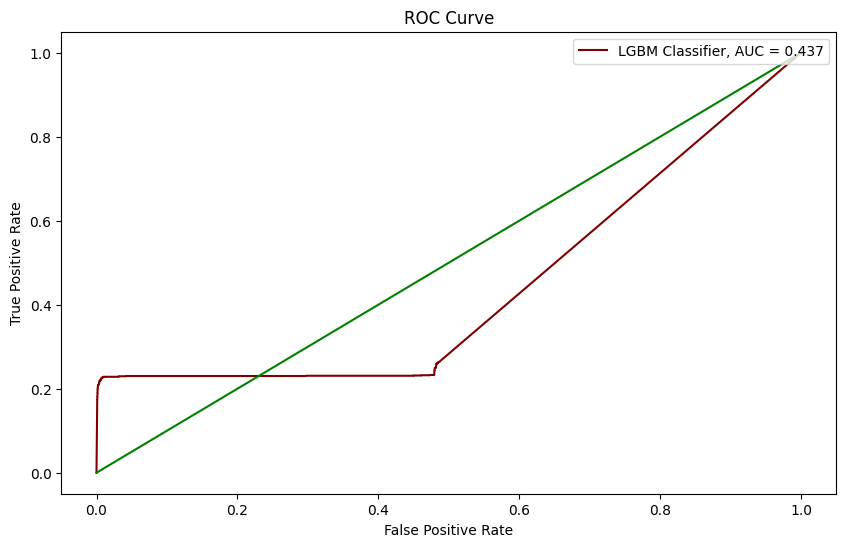

In [81]:
plt.figure(figsize=(10, 6))

plt.plot(fpr, tpr, label = 'LGBM Classifier, AUC = ' + str(auc), linestyle = 'solid', color = '#800000')
plt.plot([0, 1], [0, 1], color = 'g')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'upper right')

#### Extreme Gradient Boosting Classifier

Model evalution Based on **ROC Curve**.

In [82]:
fpr, tpr, temp = roc_curve(y_test, xgbr_pred_proba)
auc = round(roc_auc_score(y_test, xgbr_pred_proba),3)
auc

0.999

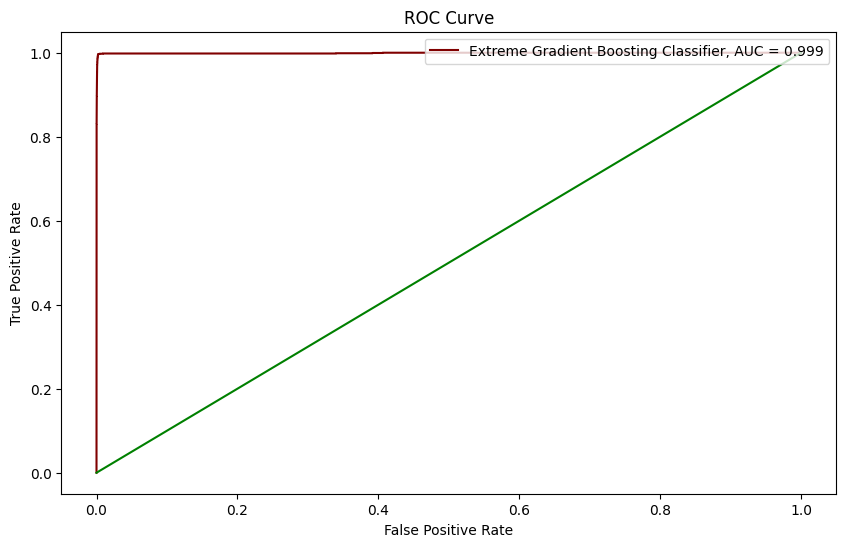

In [83]:
plt.figure(figsize=(10, 6))

plt.plot(fpr, tpr, label = 'Extreme Gradient Boosting Classifier, AUC = ' + str(auc), linestyle = 'solid', color = '#800000')
plt.plot([0, 1], [0, 1], color = 'g')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'upper right')

### False Positive Rate and True Positive Rate for each classifier

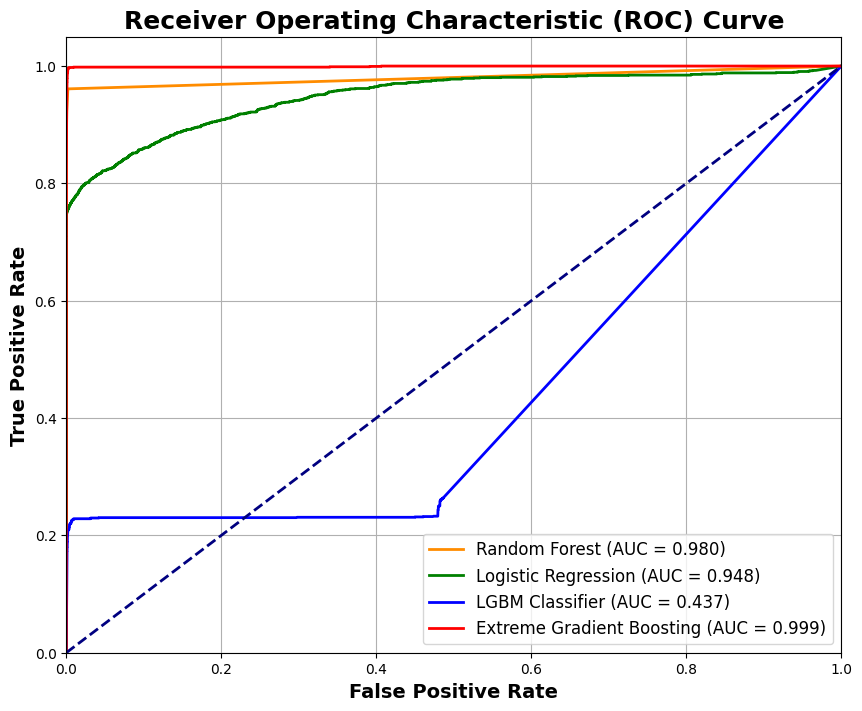

In [87]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr_rf, tpr_rf, _ = roc_curve(y_test, rfc_pred_proba)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_lr, tpr_lr, _ = roc_curve(y_test, lrc_pred_proba)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, lgbm_pred_proba)
roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgbr_pred_proba)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
plt.plot(fpr_lr, tpr_lr, color='green', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})')
plt.plot(fpr_lgbm, tpr_lgbm, color='blue', lw=2, label=f'LGBM Classifier (AUC = {roc_auc_lgbm:.3f})')
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label=f'Extreme Gradient Boosting (AUC = {roc_auc_xgb:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 14, fontweight = 'bold')
plt.ylabel('True Positive Rate', fontsize = 14, fontweight = 'bold')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize = 18, fontweight = 'bold')
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.show()
